In [1]:
import os
import numpy as np
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import matplotlib.image as mpimg
import segmentation_models_pytorch as smp
from torchmetrics.image.fid import FrechetInceptionDistance

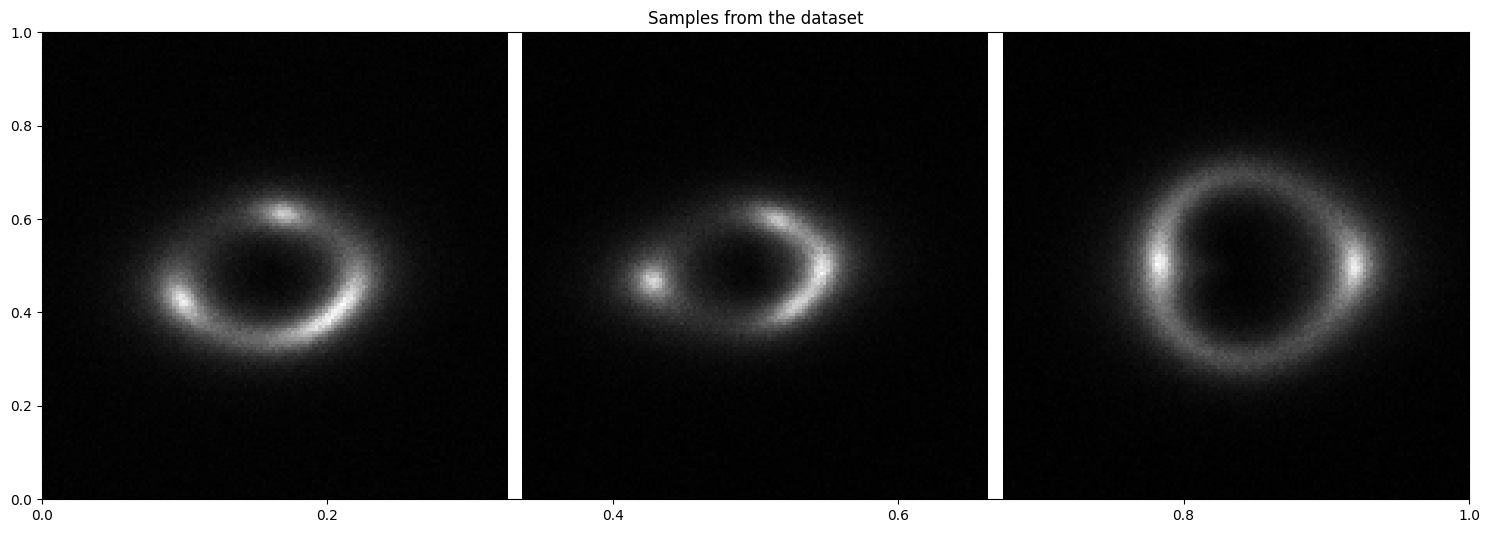

In [2]:
sample1 = np.load("/home/hamee/flow/flow_data/sample1.npy")
sample2 = np.load("/home/hamee/flow/flow_data/sample2.npy")
sample3 = np.load("/home/hamee/flow/flow_data/sample3.npy")

def plot_samples_horizontally(samples_list):
    plt.figure(figsize=(15, 5))
    
    plt.title("Samples from the dataset")
    for i, img in enumerate(samples_list):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[0], cmap="gray")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

samples = [sample1, sample2, sample3]

plot_samples_horizontally(samples)

In [3]:
torch.manual_seed(42)
np.random.seed(42)

BATCH_SIZE = 48
LEARNING_RATE = 1e-4
NUM_EPOCHS = 150

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class GravitationalLensingDataset(Dataset):
    def __init__(self, data_dir):
        self.data_files = glob.glob(os.path.join(data_dir, "*.npy"))
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data = np.load(self.data_files[idx])
        data = data.astype(np.float32)
        data = (data - data.min()) / (data.max() - data.min() + 1e-8)
        data = torch.from_numpy(data)
        
        if self.transform:
            data = self.transform(data)
            
        return data

In [5]:
class ODEFunc(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model_dtype = next(model.parameters()).dtype
        
    def forward(self, t, x):
        # t is scalar, x is tensor of shape [batch_size, channels, height, width]
        batch_size = x.shape[0]
        t_batch = torch.ones(batch_size, device=x.device, dtype=self.model_dtype) * t
        
        # Compute vector field
        v_t = self.model(x, t_batch)
        return -v_t

In [6]:
class SinusPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x, scale=1000):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device).float() * -emb)
        emb = scale * x.unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class TimeEmbedding(nn.Module):
    def __init__(self, dim, freq_embed_dim=256):
        super().__init__()
        self.time_embed = SinusPositionEmbedding(freq_embed_dim)
        self.time_mlp = nn.Sequential(nn.Linear(freq_embed_dim, dim), nn.SiLU(), nn.Linear(dim, dim))

    def forward(self, timestep):
        time_hidden = self.time_embed(timestep)
        time_hidden = time_hidden.to(timestep.dtype)
        time = self.time_mlp(time_hidden)  # b d
        return time

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.unet = smp.UnetPlusPlus(
            encoder_name="resnet34",    
            encoder_weights="imagenet",        
            in_channels=in_channels,      
            classes=out_channels,      
        )
        
        self.time_embed = TimeEmbedding(256)
        
        self.time_proj = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(128, out_channels, kernel_size=1)
        )

    def forward(self, x, t):
        t_emb = self.time_embed(t)
        unet_out = self.unet(x)
    
        batch_size = x.shape[0]
        t_emb = t_emb.view(batch_size, -1, 1, 1).expand(-1, -1, x.shape[2], x.shape[3])
                
        time_out = self.time_proj(t_emb)
        
        return unet_out + time_out

In [8]:
class FlowMatching(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, x, t):
        return self.unet(x, t)

In [9]:
def generate_samples(model, x=None, steps=50, num_samples=1, image_size=224):
    model.eval()
    model_dtype = next(model.parameters()).dtype
    
    if x is None:
        x = torch.randn(num_samples, 1, image_size, image_size, dtype=model_dtype).to(DEVICE)
    else:
        x = x.to(device=DEVICE, dtype=model_dtype)
    
    with torch.no_grad():
        ode_func = ODEFunc(model)
        
        integration_times = torch.linspace(0, 1, steps, dtype=model_dtype).to(DEVICE)
        samples = odeint(
            ode_func,
            x,
            integration_times,
            method='euler',
        )
        
        samples = samples[-1]
        
        samples = torch.clamp(samples, -1, 1)
    
    return samples

In [ ]:
def train_flow_matching(model, data_loader, optimizer, num_epochs=NUM_EPOCHS):
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, data in enumerate(progress_bar):
            data = data.to(DEVICE)
            batch_size = data.shape[0]
            
            noise = torch.randn_like(data).to(DEVICE)
            
            t = torch.rand(batch_size).to(DEVICE)
            
            # linear interpolation
            x_t = (1 - t.view(-1, 1, 1, 1)) * data + t.view(-1, 1, 1, 1) * noise
            
            v_t = noise - data
            
            pred_v_t = model(x_t, t)
            
            loss = F.mse_loss(pred_v_t, v_t)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})
        
        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")
        
        if (epoch + 1) % 10 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'loss': avg_loss,
            }, f"flow_matching_checkpoint_epoch_{epoch+1}.pt")
            
            with torch.no_grad():
                samples = generate_samples(model, num_samples=4)
                save_image(samples, f"samples_epoch_{epoch+1}.png", normalize=True)
    
    return model, losses

In [11]:
data_dir = "flow_data"
    
dataset = GravitationalLensingDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

unet = UNet(in_channels=1, out_channels=1).to(DEVICE)
model = FlowMatching(unet).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
model, loss_history = train_flow_matching(model, dataloader, optimizer, num_epochs=150)

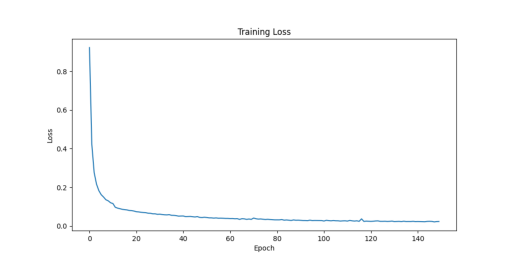

In [ ]:
def plot_loss():
    img = mpimg.imread("training_loss.png")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

plot_loss()

In [12]:
def load_flow_model(compile=False, use_half_precision=False):
    unet = UNet(in_channels=1, out_channels=1)
    model = FlowMatching(unet)
    checkpoint = torch.load("best_diffusion_model_unconditional_unet.pt", map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    if compile:
        model = torch.compile(model, mode="reduce-overhead")
    
    if use_half_precision:
        dtype = torch.half
    else:
        dtype = torch.float32

    model = model.to(dtype=dtype, device=DEVICE)
    return model.eval()

model = load_flow_model(compile=True, use_half_precision=True)

/var/tmp/ipykernel_808785/2687510383.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/hamee/flow/resnet34_diffusion_ckpts/flow_matching_fin

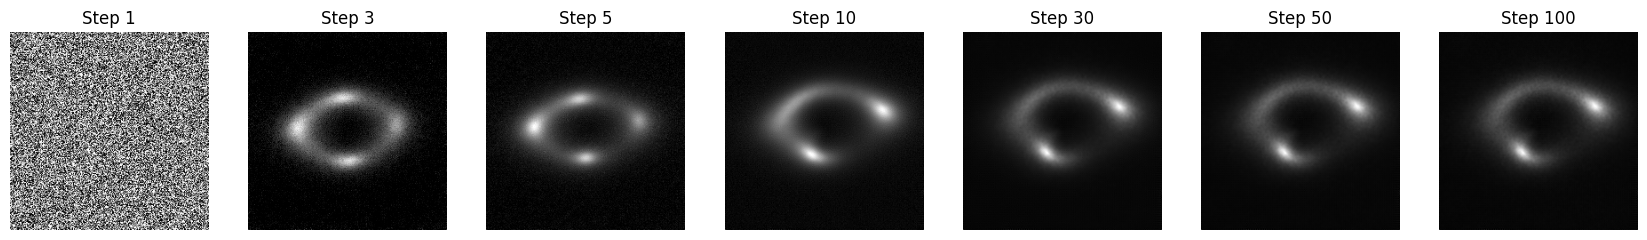

In [13]:
def plot_samples(step_indices=[1, 3, 5, 10, 30, 50, 100]):
    _, axes = plt.subplots(1, len(step_indices), figsize=(len(step_indices) * 3, 3))
    
    x = torch.randn(1, 1, 224, 224)
    for idx, step in enumerate(step_indices):
        img = generate_samples(model, x, steps=step).squeeze().cpu().numpy()  # Convert tensor to NumPy array
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"Step {step}")
    
    plt.show()

plot_samples()

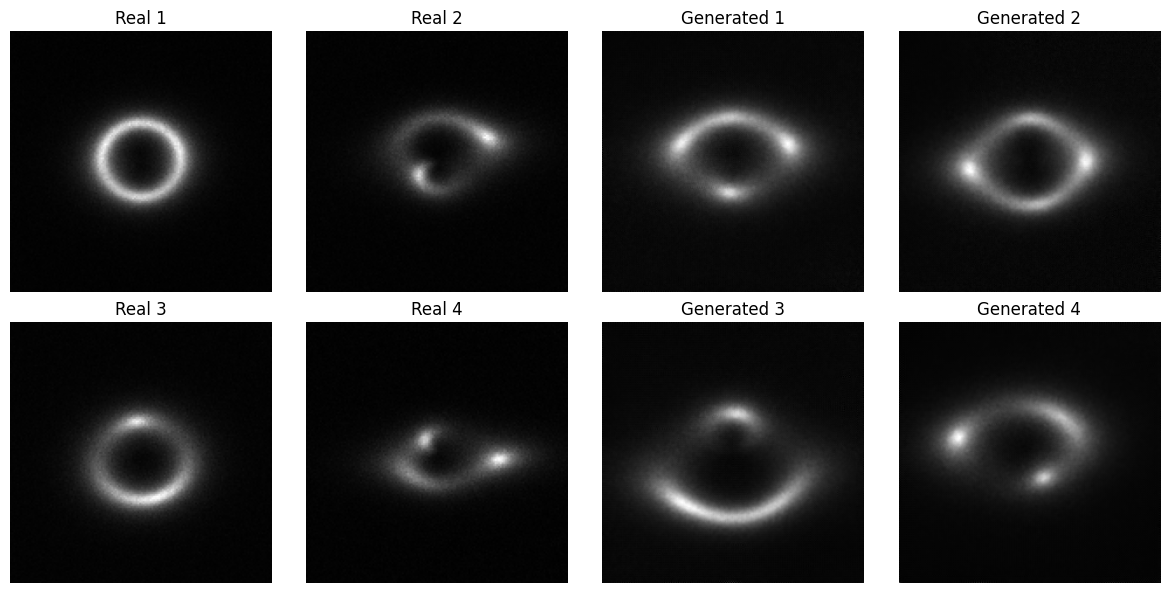

In [ ]:
def load_npy_images(directory):
    npy_files = [f for f in os.listdir(directory)[60:64]]
    real_images = [np.load(os.path.join(directory, f)) for f in npy_files]
    return real_images

def plot_real_vs_generated(model, data_dir, num_pairs=4, steps=50):
    real_images = load_npy_images(data_dir)
    generated_images = generate_samples(model, num_samples=num_pairs, steps=steps).squeeze().cpu().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    # Plot real images on the left columns
    for i in range(4):
        row, col = divmod(i, 2)
        
        # Plot real images in columns 0 and 1
        axes[row, col].imshow(real_images[i].squeeze(), cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Real {i+1}")
        
        # Plot generated images in columns 2 and 3
        axes[row, col+2].imshow(generated_images[i].squeeze(), cmap='gray')
        axes[row, col+2].axis('off')
        axes[row, col+2].set_title(f"Generated {i+1}")
    
    plt.tight_layout()
    plt.show()


plot_real_vs_generated(model, data_dir)

In [14]:
def prepare_images_for_fid(images):
    if images.size(1) == 1:
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    return images

def calculate_fid_score(real_dataloader, model, num_samples=10000):
    fid = FrechetInceptionDistance(normalize=False)
    
    real_images = []
    for data in tqdm(real_dataloader, desc="Collecting real images"):
        real_images.append(data.cpu())
        if len(torch.cat(real_images)) >= num_samples:
            break
    
    real_images = torch.cat(real_images, dim=0)[:num_samples]
    
    generated_images = []
    batch_size = 4 
    
    for i in tqdm(range(0, num_samples, batch_size), desc="Generating samples"):
        current_batch = min(batch_size, num_samples - i)
        if current_batch <= 0:
            break
        
        samples = generate_samples(model, num_samples=current_batch, steps=50)
        generated_images.append(samples.cpu())
        
        torch.cuda.empty_cache()
    
    generated_images = torch.cat(generated_images, dim=0)[:num_samples]
    
    fid = fid.to(DEVICE)  
    
    batch_size = 32 
    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)
        
        real_batch = real_images[i:end_idx].to(DEVICE)
        real_batch = prepare_images_for_fid(real_batch)
        fid.update(real_batch, real=True)
        del real_batch
        
        gen_batch = generated_images[i:end_idx].to(DEVICE)
        gen_batch = prepare_images_for_fid(gen_batch)
        fid.update(gen_batch, real=False)
        del gen_batch
        
        torch.cuda.empty_cache()
    
    print("Computing FID score...")
    fid_score = fid.compute()
    
    return fid_score.item()


fid_score = calculate_fid_score(dataloader, model)

Generating samples: 100%|██████████| 2500/2500 [15:25<00:00,  2.70it/s]


Computing FID score...


In [15]:
print(f"FID score: {fid_score:.4f}")

FID score: 34.8437


In [20]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

iters = 100
start_event.record()
for _ in tqdm(range(iters)):
    generate_samples(model, num_samples=1, steps=50)
end_event.record()

torch.cuda.synchronize()
elapsed_time = start_event.elapsed_time(end_event) / iters

100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


In [21]:
print(f"Latency: {elapsed_time:.4f} ms")

Latency: 123.3365 ms
